# We cannot use callable functions for bouncing sphere, the function is not injective. we need to make the x axis time instead of location

check ms word File for control volume

From Masked data?

In [28]:
from_masked = False

Imports

In [29]:
import My_functions as Mf
import os
import numpy as np
import scipy
from scipy.constants import g, pi
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [30]:
def read_text_from_file(filename):
    """
    Reads text from a file.

    Args:
        filename (str): The name of the file to read from.

    Returns:
        str: The text read from the file.
    """
    with open(filename, 'r') as file:
        text = file.read()
    return text

load data

In [31]:
the_big_pickle_path = r'C:\Users\Morten\OneDrive - mail.tau.ac.il\Thesis\Shared Folder\Excel Files\The Big Pickle.pkl'
parent_folder = os.path.dirname(os.getcwd()) #on notebok only. in .py file its different
save_folder = os.path.join(parent_folder, 'output')
# save_folder = Mf.select_directory()

save_folder_multy = os.path.join(save_folder, 'Multy')

multy_cut_image = 'multy_cut_image'
if from_masked:
    multy_cut_image = multy_cut_image+ '_masked'
multy_cut_image_folder = os.path.join(save_folder_multy, multy_cut_image)


name_of_file_PTV = 'data_from_PTV.pkl'
name_of_file_PIV = 'data_from_PIV.pkl'
if from_masked:
    name_of_file_PIV = name_of_file_PIV[:-4] + '_Mask.pkl'


Experiment_Id = read_text_from_file(os.path.join(save_folder, 'Experiment Id.txt'))
current_data =  Mf.load_pickle(the_big_pickle_path)[Experiment_Id]
# print(current_data.keys())

y_location_meter_cutted, y_times_cutted, y_velocity_meter_cutted = current_data['Vertical Location For Velocity [m] list'], current_data['Velocity Times [sec] list'], current_data['Velocity [m/s] list']
sphere_location_absolute, PIV_origin_location, Selected_area_for_PIV, scaling_factor, object_range, sphere_location_relative, origin, clean_times = Mf.load_pickle(os.path.join(save_folder, name_of_file_PIV))

extract parameters from cihx and excel

In [32]:
upper_viscosity, lower_viscosity, upper_density, lower_density, Interface_thickness, sphere_diameter, rho_sphere, sphere_type, Interface_height \
      = Mf.load_data_for_demintionless_number(experiment_date = Mf.read_data_from_cihx(save_folder, '<date>'))

round_number = int(os.path.splitext(Mf.files_in_folder(save_folder, 'cihx')[0])[0][-2:])
real_sphere_density = Mf.extract_data_from_excel_two_parameters(desired_row = Mf.convert_date(Mf.read_data_from_cihx(save_folder, '<date>')),
                                                                desired_row2 = round_number, base_column2 = 'Record number',
                                                                data_column='Calculated sphere density [kg/m^3]')
if real_sphere_density is None:
      print('didnt find density in excel file')
      real_sphere_density = rho_sphere

In [33]:
print(f'rho_sphere = {real_sphere_density} [kg/m^3]\nsphere_diameter = {sphere_diameter*1000} [mm]')
sphere_volume = 4/3*pi*(sphere_diameter/2)**3
sphere_mass = rho_sphere*sphere_volume
sphere_mass = real_sphere_density*sphere_volume
mg = sphere_mass*g
print(f'mg = {mg} [N]')

rho_sphere = 1110.546944927082 [kg/m^3]
sphere_diameter = 10.0 [mm]
mg = 0.0057023808507479104 [N]


Plots velocities

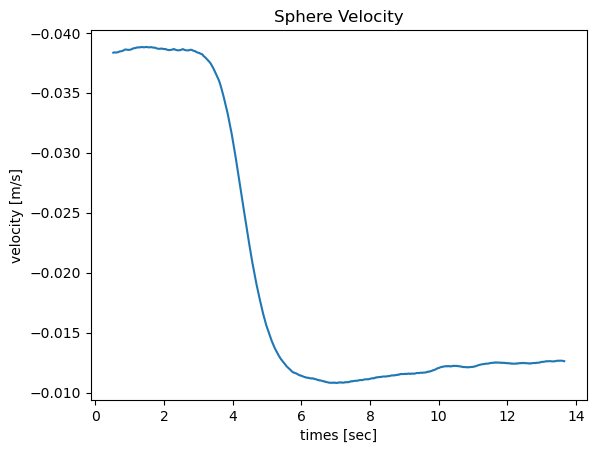

In [34]:
times_PTV = np.array(y_times_cutted)
y_locations = np.array(y_location_meter_cutted)
velocitys_meter_PTV = np.array(y_velocity_meter_cutted)




plt.plot(times_PTV, velocitys_meter_PTV, label='Sphere Velocity')
plt.xlabel('times [sec]')
plt.ylabel('velocity [m/s]')
plt.title("Sphere Velocity")
plt.gca().invert_yaxis()
plt.show()


Creating a callable function of y location vs y velocity

$\color{red}$ Now we will set the sphere location with respect to PIV rectangle origin bottom left corner

In [35]:
time_to_location = Mf.create_callable_function_of_data(times_PTV, y_locations)
time_to_velocity = Mf.create_callable_function_of_data(times_PTV, velocitys_meter_PTV)

In [36]:
#make "sphere location" origin (0,0) same as PIV origin (0,0)
sphere_location_relative_to_piv=[]
for ind,el in enumerate(sphere_location_absolute):
    sphere_location_relative_to_piv.append([el[0]-PIV_origin_location[ind][0], el[1]-PIV_origin_location[ind][1]])

# in pixel
sphere_location_pixel = np.array(sphere_location_relative_to_piv)*scaling_factor

manual density function, do not delete

In [37]:
# interface_upper_location = Interface_height + Interface_thickness/2 #[m]
# interface_lower_location = Interface_height - Interface_thickness/2 #[m]
# amplitude = (lower_density-upper_density)/2
# middle_of_density = np.mean([upper_density, lower_density])
# interface_center = np.mean([interface_upper_location, interface_lower_location]) #[m]
# interface_width = interface_upper_location-interface_lower_location #[m]


# rho_function = Mf.density_function(amplitude = amplitude, interface_width = interface_width, center_of_interface = interface_center, mean_density_value = middle_of_density, plot = False)

# if True:
#     x_values = np.linspace(interface_center-interface_center*0.1, interface_center+0.1*interface_center, 1000)
#     y_values = rho_function(x_values)
#     plt.title('Density vs height graph')
#     plt.plot(y_values, x_values, '--', label='Density Function', color='red')
#     plt.xlabel(r'Density $ \left[ \frac {kg} {m^3} \right]$', rotation=0)
#     ylabel = plt.ylabel('Height [m]', rotation=0)
#     ylabel.set_verticalalignment('bottom')  # Align at the bottom of the label
#     ylabel.set_y(ylabel.get_position()[1] - 0)
#     plt.legend(fancybox=True, framealpha=0)
#     plt.show()

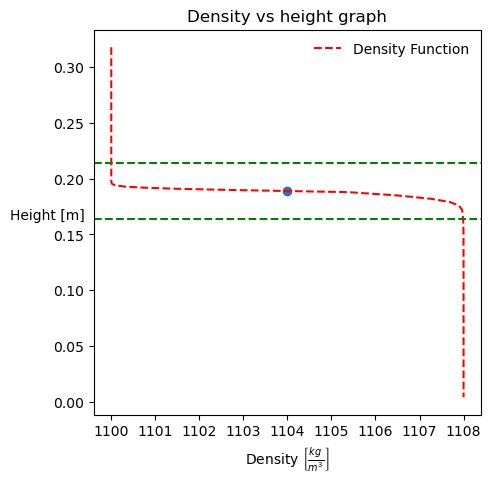

In [38]:
y_loccccc, densityccccc = Mf.load_density_profile_from_excel(date=Mf.convert_date(Mf.read_data_from_cihx(save_folder, '<date>')))
rho_function = Mf.create_callable_function_of_data(y_loccccc, densityccccc)

y_loccccc2 = np.array(y_loccccc)
densityccccc2 = np.array(densityccccc)

# x_domain = np.linspace(0, 0.6, 1000)
# Interface_thickness = Mf.find_interface_thickness_callable(x_domain, rho_function)

Interface_height = Mf.find_average_density_location(y_loccccc2, densityccccc2)


interface_lower_location = Interface_height - Interface_thickness/2
interface_width = Interface_thickness


fig, ax = plt.subplots(figsize=(5,5))

plt.title('Density vs height graph')
plt.plot(densityccccc2, y_loccccc2, '--', label='Density Function', color='red')
plt.xlabel(r'Density $ \left[ \frac {kg} {m^3} \right]$', rotation=0)
ylabel = plt.ylabel('Height [m]', rotation=0)
plt.scatter(rho_function(Interface_height), Interface_height)

# Interface
plt.axhline(Interface_height-Interface_thickness/2, linestyle='--', color='green')
plt.axhline(Interface_height+Interface_thickness/2, linestyle='--', color='green')
plt.legend(fancybox=True, framealpha=0)
plt.show()

In [39]:
F_y = []
F_y_and_loc = []
F_y_and_time = []

txt_files_path = Mf.files_in_folder(save_folder_multy, 'txt', full_path = True)
txt_files_path_1 = []


for el in txt_files_path:
    if from_masked:
        if "masked" in el:
            txt_files_path_1.append(el)
    else:
        if not "masked" in el:
            txt_files_path_1.append(el)

txt_files_path = txt_files_path_1
txt_files_path_1 = 0

The force acting on the water

<img title="Control Volume Integral" alt="Alt text" src="../Picture/IMG for markdown/control_vol_int.png">

we need to find the relevant place in Y for sum1 and sum2, and to cut the list for -2a<x<2a

DO NOT DEL, THIS IS FOR A SPECIFIC CONTROL VOLUME INSIDE OF THE FRAME

take max control volume (as size of window)

In [40]:
for ind, el in enumerate(txt_files_path):
    x, y, u, v = Mf.txt_to_column(txt_files_path[ind])

    start_y_upper, end_y_upper = Mf.find_closest_range_to_values_in_array(y, y[0]) #return indexes
    start_y_lower, end_y_lower = Mf.find_closest_range_to_values_in_array(y, y[-1]) #return indexes


    start_x = Mf.find_closest_values_in_array(x, x[0]) #return indexes
    end_x = Mf.find_closest_values_in_array(x, x[-1]) #return indexes

    v_upper = v[start_y_upper: end_y_upper + 1][start_x: end_x + 1] # [m/s]
    v_lower = v[start_y_lower: end_y_lower + 1][start_x: end_x + 1] # [m/s]

    x_values = x[start_x: end_x + 1] # [m]


    #note: sphere_velocity[ind][1] is the control volume velocity V_c
    w_squared_upper = (np.array(v_upper) - time_to_velocity(clean_times[ind]))**2 # [m^2 / s^2]
    w_squared_lower = (np.array(v_lower) - time_to_velocity(clean_times[ind]))**2 # [m^2 / s^2]
    
    #this is numeric integration, there is an uncertanty
    sum_upper = scipy.integrate.trapz(w_squared_upper, x_values) # [m^3 / s^2]
    sum_lower = scipy.integrate.trapz(w_squared_lower, x_values) # [m^3 / s^2]
    
    # # try Simpson rule
    sum_upper = scipy.integrate.simps(w_squared_upper, x_values) # [m^3 / s^2]
    sum_lower = scipy.integrate.simps(w_squared_lower, x_values) # [m^3 / s^2]
    

    
    # the force acting on the WATER:
    F_y_el = 4*sphere_diameter*(rho_function(y[0] + PIV_origin_location[ind][1])*sum_upper - rho_function(y[-1] + PIV_origin_location[ind][1])*sum_lower) # [N]


    # appending the force acting on the SPHERE not on the water:
    F_y.append(-F_y_el)
    F_y_and_loc.append([sphere_location_absolute[ind][1], -F_y_el])
    F_y_and_time.append([clean_times[ind], -F_y_el])

Force from control volume is the dynamic force.

the bouyance force in present even if the flow field is zero and the water is stationary.

save files

In [41]:
save_file_name = 'Force_from_control_volume.pkl'
if from_masked:
    save_file_name = save_file_name[:-4] + '_Mask.pkl'

file_path = os.path.join(save_folder, save_file_name)
Mf.save_pickle(file_path, F_y)

The file "Force_from_control_volume.pkl" has been saved at: c:\Users\Morten\OneDrive - mail.tau.ac.il\Thesis\Python Thesis\Analysis\output


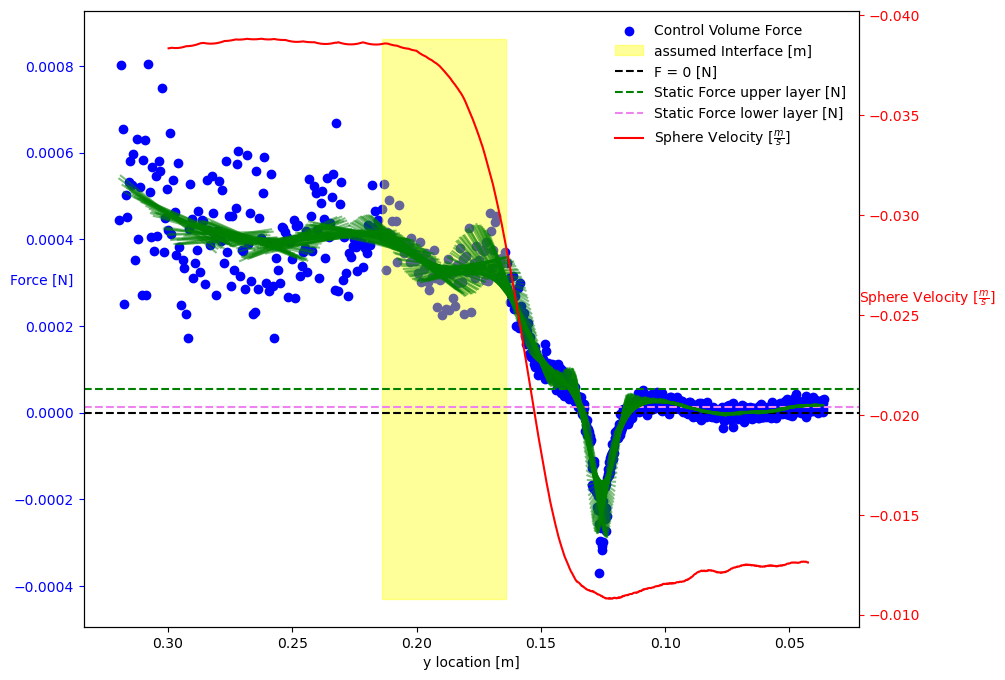

In [42]:
F_y_and_loc_np = np.array(F_y_and_loc)
# Create a figure and left axis
fig, ax1 = plt.subplots(figsize=(10, 8))
# plt.title('Combined Graph')

# Plot the data for the left axis (Force vs Location)
ax1.scatter(F_y_and_loc_np[:, 0], F_y_and_loc_np[:, 1], label='Control Volume Force', color='blue')

# Define the coordinates and dimensions of the rectangle
rect_x = interface_lower_location #[m]
rect_width = interface_width
rect_y = ax1.get_ylim()[0]
rect_height = ax1.get_ylim()[1] - rect_y # Cover the entire y-axis range

# # Create a Rectangle patch with transparency (alpha)
rect_patch = patches.Rectangle((rect_x, rect_y), rect_width, rect_height, alpha=0.4, color='yellow', label='assumed Interface [m]')
ax1.add_patch(rect_patch)

ax1.axhline(y=0, color='black', linestyle='--', label='F = 0 [N]')
ax1.axhline(y=-rho_function(0.6)*sphere_volume*g+mg, color='green', linestyle='--', label='Static Force upper layer [N]')
ax1.axhline(y=-rho_function(0)*sphere_volume*g+mg, color='violet', linestyle='--', label='Static Force lower layer [N]')

ax1.set_xlabel('y location [m]')
ax1.set_ylabel('Force [N]', color='blue', rotation=0, labelpad=-20, y=0.55)
ax1.tick_params('y', colors='blue')
# ax1.legend(loc='upper left', fancybox=True, framealpha=0)



# Create a twin axis for the right axis (Sphere Velocity)
ax2 = ax1.twinx()
ax2.plot(y_locations, velocitys_meter_PTV, color='red', label=r'Sphere Velocity $ \left[ \frac {m} {s} \right]$')
ax2.set_ylabel(r'Sphere Velocity $ \left[ \frac {m} {s} \right]$', color='red', rotation=0, labelpad=5, y=0.55)

ax2.tick_params('y', colors='red')

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, fancybox=True, framealpha=0)

# Invert x-axis
ax1.invert_xaxis()
ax2.invert_yaxis()


# save?
plt.savefig(os.path.join(save_folder, 'Combined Graph.svg'), transparent=True, bbox_inches='tight')
# plt.savefig(os.path.join(save_folder, 'Combined Graph.png'), transparent=True, bbox_inches='tight', dpi = 1000)
# plt.savefig(os.path.join(save_folder, 'Combined Graph.eps'), transparent=True, bbox_inches='tight')


the_number = 60
plot_precentage = 1
for i in range(len(F_y_and_loc_np) - the_number):
    if i<(len(F_y_and_loc_np) - the_number)*plot_precentage:
        x_fit = F_y_and_loc_np[i:i+the_number+1, 0]
        y_fit = F_y_and_loc_np[i:i+the_number+1, 1]
        
        # Use np.polyfit to perform the least squares fit
        coefficients = np.polyfit(x_fit, y_fit, deg=1)
        
        # Create a smooth x-axis range for plotting the fitted curve
        x_smooth = np.linspace(x_fit.min(), x_fit.max(), 100)
        
        # Plot the fitted curve
        ax1.plot(x_smooth, np.polyval(coefficients, x_smooth), color='green', alpha=0.5)


# Show the plot
plt.show()

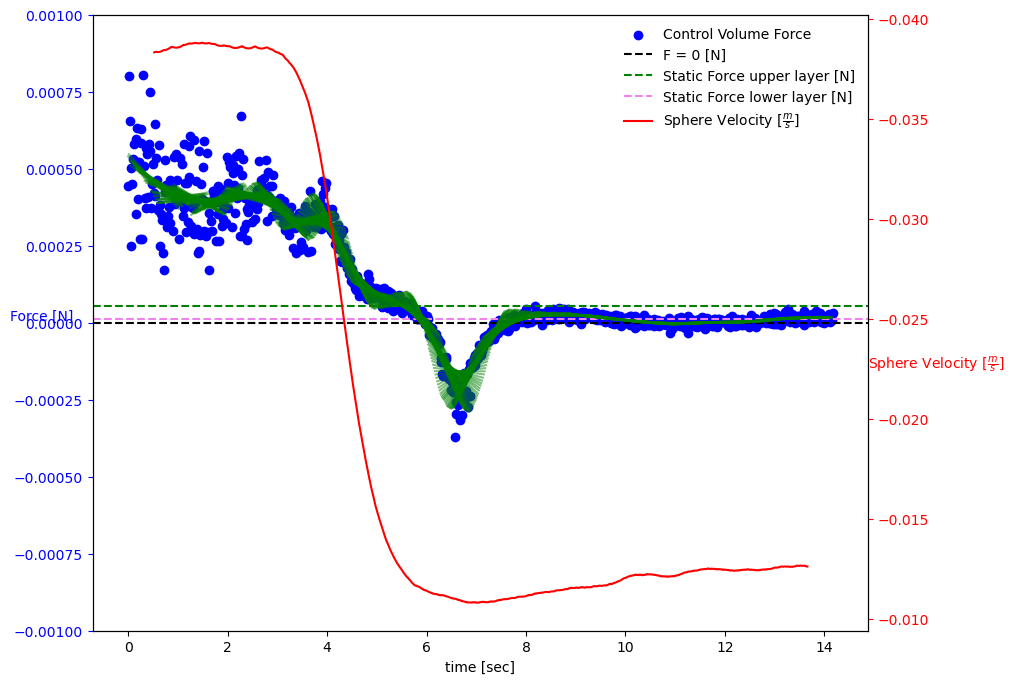

In [43]:
F_y_and_time_np = np.array(F_y_and_time)

fig, ax1 = plt.subplots(figsize=(10, 8))

ax1.scatter(F_y_and_time_np[:, 0], F_y_and_time_np[:, 1], label='Control Volume Force', color='blue')
ax1.axhline(y=0, color='black', linestyle='--', label='F = 0 [N]')
ax1.axhline(y=-rho_function(0.6)*sphere_volume*g+mg, color='green', linestyle='--', label='Static Force upper layer [N]')
ax1.axhline(y=-rho_function(0)*sphere_volume*g+mg, color='violet', linestyle='--', label='Static Force lower layer [N]')

ax1.set_xlabel('time [sec]')
ax1.set_ylabel('Force [N]', color='blue', rotation=0, labelpad=-20, y=0.5)
ax1.tick_params('y', colors='blue')


ax2 = ax1.twinx()
ax2.plot(times_PTV, velocitys_meter_PTV, color='red', label=r'Sphere Velocity $ \left[ \frac {m} {s} \right]$')
ax2.set_ylabel(r'Sphere Velocity $ \left[ \frac {m} {s} \right]$', color='red', rotation=0, labelpad=5, y=0.45)

ax2.tick_params('y', colors='red')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, fancybox=True, framealpha=0)

ax2.invert_yaxis()


# save?
plt.savefig(os.path.join(save_folder, 'Combined Graph_time.svg'), transparent=True, bbox_inches='tight')

the_number = 60
plot_precentage = 1
for i in range(len(F_y_and_time_np) - the_number):
    if i<(len(F_y_and_time_np) - the_number)*plot_precentage:
        x_fit = F_y_and_time_np[i:i+the_number+1, 0]
        y_fit = F_y_and_time_np[i:i+the_number+1, 1]

        coefficients = np.polyfit(x_fit, y_fit, deg=1)
        x_smooth = np.linspace(x_fit.min(), x_fit.max(), 100)
        ax1.plot(x_smooth, np.polyval(coefficients, x_smooth), color='green', alpha=0.5)

# ax1.set_xlim(0, 16)
ax1.set_ylim(-0.001,0.001)
plt.show()

Lets make a Cd graph
$ C_d = \frac{F}{\frac{1}{2}\rho U^2 \cdot S_p} $

where $S_p = \frac{\pi \cdot ({sphere\ diameter})^2} {4}$ is the projected surface area

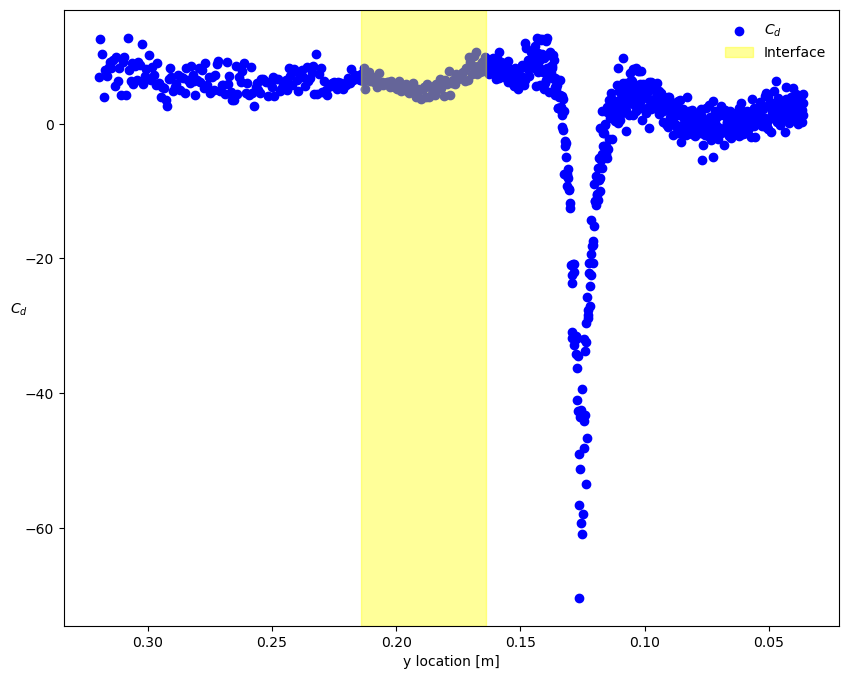

In [44]:
C_d_and_loc = np.copy(F_y_and_loc_np)
C_d_and_loc[:,1] = C_d_and_loc[:,1]/(0.5*(np.pi/4*sphere_diameter**2)*rho_function(C_d_and_loc[:,0])*time_to_velocity(F_y_and_time_np[:,0])**2)


fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(C_d_and_loc[:,0], C_d_and_loc[:,1], label='$C_d$', color = 'blue')

# Define the coordinates and dimensions of the rectangle
rect_x = interface_lower_location #[m]
rect_width = interface_width
rect_y = ax.get_ylim()[0]  # Start from y=0
rect_height = ax.get_ylim()[1] - rect_y # Cover the entire y-axis range

# Create a Rectangle patch with transparency (alpha)
rect_patch = patches.Rectangle((rect_x, rect_y), rect_width, rect_height, alpha=0.4, color='yellow', label='Interface')
ax.add_patch(rect_patch)

ax.set_xlabel('y location [m]')
ax.set_ylabel('$C_d$', rotation=0)
ax.legend(fancybox=True, framealpha=0)
# ax.set_xlim(0,0.18)
plt.gca().invert_xaxis()
plt.savefig(os.path.join(save_folder, 'C_d.svg'), transparent=True, bbox_inches='tight')

plt.show()

בחלקים בהם המהירות היא 0 מקדם הגרר ישאף לאינסוף

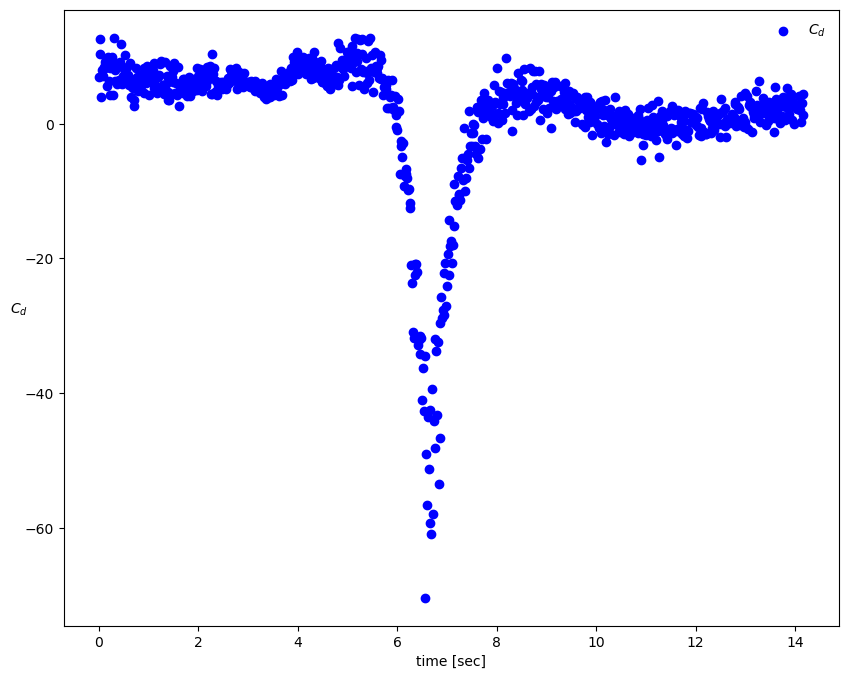

In [45]:
C_d_and_loc = np.copy(F_y_and_loc_np)
C_d_and_loc[:,1] = C_d_and_loc[:,1]/(0.5*(np.pi/4*sphere_diameter**2)*rho_function(C_d_and_loc[:,0])*time_to_velocity(F_y_and_time_np[:,0])**2)


fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(F_y_and_time_np[:,0], C_d_and_loc[:,1], label='$C_d$', color = 'blue')

ax.set_xlabel('time [sec]')
ax.set_ylabel('$C_d$', rotation=0)
ax.legend(fancybox=True, framealpha=0)
# ax.set_xlim(0,0.18)
# plt.gca().invert_xaxis()
# ax.set_xlim(0,0.1)

plt.savefig(os.path.join(save_folder, 'C_d_time.svg'), transparent=True, bbox_inches='tight')

plt.show()

optional show streamline.

need to be fixed

In [46]:
if False:
    pictures_list = Mf.find_pictures(multy_cut_image_folder)
    new_multy_cut_image_folder = os.path.join(multy_cut_image_folder, 'edited')
    Mf.create_directory(new_multy_cut_image_folder)
    for ind, el in enumerate(sphere_location_relative_to_piv):
        img = Mf.read_image(pictures_list[ind])
        Mf.save_stream_line_on_pic(txt_files_path[ind], save_path=os.path.join(new_multy_cut_image_folder, os.path.basename(pictures_list[ind])), scale=0.01, width = 0.003,scaling_factor=scaling_factor, on_img=True, image_name=pictures_list[ind])
        plt.close()
    Mf.display_images_with_points_napari(new_multy_cut_image_folder)